In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
dfJun = pd.read_csv("C:/Users/brand/OneDrive/Documents/IDX Exchange/CRMLSSold202406_filled.csv")

In [44]:
dfJun = dfJun[(dfJun["PropertyType"] == "Residential") & (dfJun["PropertySubType"] == "SingleFamilyResidence")]

selected_cols = [
    "PoolPrivateYN", "ViewYN", "OriginalListPrice", "TaxAnnualAmount", 
    "BedroomsTotal", "BathroomsTotalInteger", "YearBuilt", "BasementYN", 
    "LivingArea", "PostalCode", "Flooring", "AttachedGarageYN"
]
df_clean = dfJun[selected_cols].copy()

dfJun["OriginalListPrice"] = dfJun["OriginalListPrice"].fillna(dfJun["OriginalListPrice"].mean())
df_clean["log_price"] = np.log1p(df_clean["OriginalListPrice"])

# fill numeric columns with median
num_cols = ["OriginalListPrice", "TaxAnnualAmount", "BedroomsTotal", 
            "BathroomsTotalInteger", "YearBuilt", "LivingArea"]
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

binary_cols = ["PoolPrivateYN", "ViewYN", "BasementYN", "AttachedGarageYN"]

# fill NaNs with "N" before conversion
df_clean[binary_cols] = df_clean[binary_cols].fillna("N")

# convert "Y" into 1, "N" into 0, and change type to integer
df_clean[binary_cols] = df_clean[binary_cols].replace({"Y": 1, "N": 0}).astype(int)

# fill categorical variables with "Unknown"
cat_cols = ["Flooring", "PostalCode"]
df_clean[cat_cols] = df_clean[cat_cols].fillna("Unknown")

df_clean["PostalCode"] = df_clean["PostalCode"].astype("category").cat.codes
df_clean["Flooring"] = df_clean["Flooring"].astype("category").cat.codes

In [45]:
X = df_clean.drop(columns=["log_price","OriginalListPrice"])
Y = df_clean["log_price"]

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [47]:
Y_pred = rf.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error is {mse:.4f}")
print(f"R2 Score is {r2:.4f}")

Mean Squared Error is 0.1344
R2 Score is 0.7344


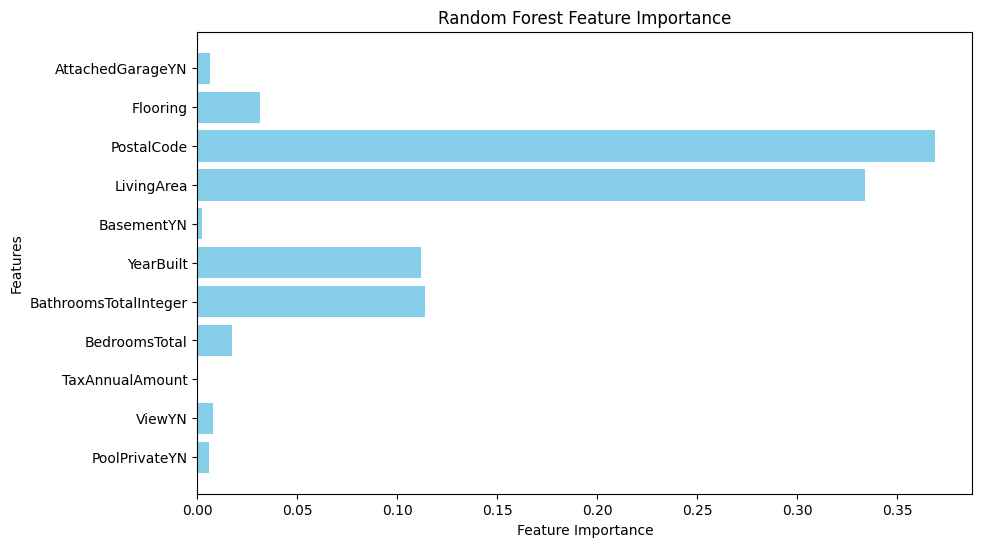

In [27]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()


In [48]:
new_features = [
    "DaysOnMarket", "LotSizeSquareFeet", "Stories", "GarageSpaces", "ParkingTotal",
    "NewConstructionYN", "HighSchoolDistrict", "SubdivisionName", "MLSAreaMajor"
]

df_new = dfJun[new_features + ["OriginalListPrice"]].copy()


In [49]:
num_cols = ["DaysOnMarket", "LotSizeSquareFeet", "Stories", "GarageSpaces", "ParkingTotal", "OriginalListPrice"]
df_new[num_cols] = df_new[num_cols].fillna(df_new[num_cols].median())

cat_cols = ["SubdivisionName", "MLSAreaMajor", "HighSchoolDistrict"]
df_new[cat_cols] = df_new[cat_cols].fillna("Unknown")

df_new["NewConstructionYN"] = df_new["NewConstructionYN"].fillna("N")
df_new["NewConstructionYN"] = df_new["NewConstructionYN"].replace({"Y": 1, "N": 0}).astype(int)

df_new["SubdivisionName"] = df_new["SubdivisionName"].astype("category").cat.codes
df_new["MLSAreaMajor"] = df_new["MLSAreaMajor"].astype("category").cat.codes
df_new["HighSchoolDistrict"] = df_new["HighSchoolDistrict"].astype("category").cat.codes

df_new["log_price"] = np.log1p(df_new["OriginalListPrice"])

In [50]:
X = df_new.drop(columns=["log_price", "OriginalListPrice"])
y = df_new["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"New Model - Mean Squared Error: {mse:.4f}")
print(f"New Model - R² Score: {r2:.4f}")

New Model - Mean Squared Error: 0.2111
New Model - R² Score: 0.5827


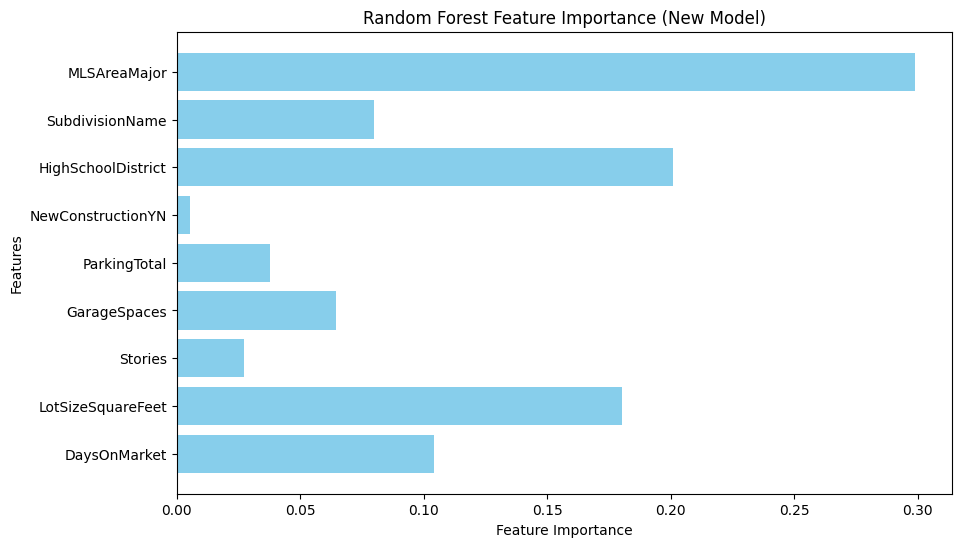

In [51]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance (New Model)")
plt.show()
